Use of Keras for NLP applications
---

---

# Natural language processing


Predicting classes from text and Reflecting language patterns in a text fragment or corpus used to train a set of neural networks.


**Index**

+ **Text Preparation or preprocessing for NLP** : fragmentation and numerical coding of text elements (link)
--> [link 1](#Parte_1)
+ **Training a classifier** : *Sentiment analysis* -Identifying sarcasm in a corpus of news headlines
--> [link 2](#Parte_2)
+ **Text generation** : Predict text with contextual learning from song lyrics from *Eurovision song contest*
--> [link 3](#Parte_3)

---

*Soruces*

Documentation from Keras : https://www.tensorflow.org/guide/keras?hl=es-419



Text corpuses:
* [*Sarcasm*](https://www.kaggle.com/datasets/minitree/eurovision-song-lyrics)
* [*Eurovision lyrics*](https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json)

Importación de módulos

In [1]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf

import pandas as pd
import sys
import re

In [2]:
import json
import matplotlib.pyplot as plt

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<a id='#Parte_1'></a>

# Parte_1

# First part : Introduction

---

These first steps describe the necessary steps for preprocessing texts, before they form the input of a neural network model.

## FIRST STEP to process a natural language : LEXICAL part --> Tokenization

Defining the lexicon or vocabulary of the language constuctions that I am going to pass to the computer is essential. It is a matter of forming a numerical dictionary of all the words that can occur in a corpus of text.

**Assign a number to each word as if it were a dictionary**

**Phrase examples - In spanish**

In [20]:
SENTENCES = [ "Me rasco la nariz", 
             "Me pica la nariz", 
             "Me rascas la nariz?", 
             "No crees que tengo una nariz bonita?"]

Using the tokenization provided by the text preprocessing module of keras/tensorflow

In [36]:
tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(SENTENCES)
word_index = tokenizer.word_index
print(word_index)

{'ombligo': 1, 'me': 2, 'el': 3, 'rasco': 4, 'pica': 5, 'rascas': 6, 'no': 7, 'crees': 8, 'que': 9, 'tengo': 10, 'un': 11, 'bonito': 12}


Manual tokenization. It does not differentiate punctuation marks or capital letters. Therefore we make use of the tokenizer provided by tensorflow.

In [24]:
chars = sorted(list(set(" ".join(SENTENCES).split())))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [25]:
char_to_int

{'Me': 0,
 'No': 1,
 'bonito?': 2,
 'crees': 3,
 'el': 4,
 'ombligo': 5,
 'ombligo!': 6,
 'pica': 7,
 'que': 8,
 'rascas': 9,
 'rasco': 10,
 'tengo': 11,
 'un': 12}

## SECOND STEP to process a natural language : SYNTAXIS --> Sequencing

This is another essential step in the preparation of the text prior to forming input in an ML method.

It involves passing the sentences present in `SENTENCES` to sequences of the numerical tokens previously prepared for each word.

In this way, the set of texts is prepared to feed a neural network and to learn the text.


For this we make use of the tokenizer provided by tensorflow again.


In [26]:
SEQUENCES = tokenizer.texts_to_sequences(SENTENCES)

In [29]:
tokenizer.fit_on_texts(SENTENCES)
word_index = tokenizer.word_index

Mapping to numbers by token and conversion of phrases to numbers (Standard label encoding)

In [30]:
# muestra de nuevo el diccionario de palabras posibles
print(word_index)

{'ombligo': 1, 'me': 2, 'el': 3, 'rasco': 4, 'pica': 5, 'rascas': 6, 'no': 7, 'crees': 8, 'que': 9, 'tengo': 10, 'un': 11, 'bonito': 12}


In [27]:
# muestra las frases de prueba
print(SEQUENCES)

[[2, 4, 3, 1], [2, 5, 3, 1], [2, 6, 3, 1], [7, 8, 9, 10, 11, 1, 12]]


What if when testing the RNN you have never seen a particular token? 

Now we prepare the case

In [32]:
testeo_tokenizacion = [ "Me chifla mi nariz", "Me chifla lo bonita que es mi nariz" ]

Note that the first sentence has a total of 4 words and the second has 8. 

There are words that have not been prepared in the token dictionary, such as `my`, `chifla` , `lo` and `es`.

In [37]:
print(tokenizer.texts_to_sequences(testeo_tokenizacion))

[[2, 1], [2, 12, 9, 1]]


The tokenizer has found a way not to put the missing words in the token set.

In this way, it has reduced the size of sentences from 4 to 2 and 8 to 4, respectively.

We would be feeding the network subsequently with the phrases `Me ombligo` and `Me bonito que ombligo`.

*But what if for the sake of grammar and reducing information loss I don't want to reduce the size of the sentences?

You can reduce these unknown tokens to the value of `OOV` by redefining the tokenizer.

In [38]:
tokenizer = Tokenizer(num_words = 100, oov_token= "<00V>")

The first token corresponds as we can see to the unknown token, `00V`.

In [41]:
print(tokenizer.word_index)

{'<00V>': 1, 'ombligo': 2, 'me': 3, 'el': 4, 'rasco': 5, 'pica': 6, 'rascas': 7, 'no': 8, 'crees': 9, 'que': 10, 'tengo': 11, 'un': 12, 'bonito': 13}


In [43]:
tokenizer.fit_on_texts(SENTENCES) # entreno con las frases iniciales
SECUENCIA_TEST = tokenizer.texts_to_sequences(testeo_tokenizacion) # convierto el texto de prueba con la tokenización anterior
print(SECUENCIA_TEST)

[[3, 1, 1, 2], [3, 1, 1, 13, 10, 1, 1, 2]]


Now we have another problem... How could our neural network interpret sentences of different sizes?

**They are modified by a process known as `padding`**.

In this process `0` is added to complete the token size of the longest sentence in the sentence corpus.

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# guardamos en la lista la longitud de cada frase pasada a secuencia de tokens
total_lens = [len(tokenlist) for tokenlist in SECUENCIA_TEST]

# hacemos el padding de las frases con el máximo de la secuencia con más carácteres
padded = pad_sequences(SECUENCIA_TEST, maxlen=max(total_lens))

print("\nPadded Test Sequence: ")
print(padded)


Padded Test Sequence: 
[[ 0  0  0  0  3  1  1  2]
 [ 3  1  1 13 10  1  1  2]]


Now all sequences have the same size

We already know how to encode the sequences to a numerical format, now we will see an example of a classifier implementation.

<a id='#Parte_2'></a>

# Parte_2

# Training a classifier to detect sentiment

---

Pre-embedding of token sequences (Continuous representation of tokens)

Implementation of a simple neural network architecture for classification.

## FIRST NEURAL NETWORK TRAINING TEST : Sentiment recognition in natural language

Training a classifier to recognize sarcasm in text.

we load the corpus of sentences with binary tags of 1 if sarcastic and 0 if not sarcastic for each sentence

In [6]:
# Textos de encabezados de artículos en internet
# Disponible en : https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

In [12]:
with open("./data/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

we load the tokenizer and do the padding of the phrases, but first we analyze what our dataset looks like

In [13]:
print("Número de headlines : ", len(sentences))

Número de headlines :  26709


In [16]:
total_lens = [len(" ".join(sentence).split()) for sentence in sentences]
print("Máximo número de palabras usadas en un headline ", max(total_lens))

Máximo número de palabras usadas en un headline  226


we use this information later for tokenization.

### Train test splitting the dataset

In [25]:
from sklearn.model_selection import train_test_split
X, y = sentences, labels
X_train, X_test, y_train, y_test =train_test_split(X, y, 
                                                   train_size=0.75, 
                                                   random_state=0, 
                                                   stratify=y, 
                                                   shuffle=True)

### TOKENIZATION


Defining the parameters of the tokenization

In [10]:
# other tokenization parameters are defined

trunc_type='post' 
padding_type='post' # padding zeros are written after tokens
oov_tok = "<OOV>" # token for unknown words

##### It is important that the tokenization process is different for the two sets.

In [26]:
# train set

tokenizer = Tokenizer(oov_token = "<00V>")
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(sequences_train, padding='post', maxlen = max(total_lens)) # decidimos que los 0 se pongan después de los tokens

In [27]:
# test set
# it is important not to make the tokenizer fitting for the test set, because we want to test it

sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, padding='post', maxlen = max(total_lens)) 
# we decided to put the 0's after the tokens

In [28]:
# we pass the phrases converted to sequences to an array

padded_train = np.array(padded_train)
padded_test = np.array(padded_test)

In [38]:
train_lexicon_length = len(list(tokenizer.word_index.keys()))
print("Número de palabras en el set de entrenamiento : ", train_lexicon_length)

Número de palabras en el set de entrenamiento :  25642


The number of words specified in the training model will be rounded to the nearest thousand.

#### These parameters should be taken into account when choosing embedding parameters

In [39]:
# maximum number of mapping that the tokenization can do (lexicon size or possible words)
vocab_size = 26000 
# number of features to which we are going to summarize the token vector
embedding_dim = 16 
# maximum token length
max_length = 100 

## Cargamos el modelo

Sequential model : It is a process that concatenates the architectures into a single model.


* **Layer of embedding `Embedding` :**  It maps the sequence of tokens to a representation in real numbers of these vectors to feed it later to the neural network. Each token is composed of vectors of dimension 16.

* **Layer of global average pooling `GlobalAveragePooling1D` :**  reduces each element of the embedding to one dimension by averaging, to feed a single vector corresponding to the sequence to the neural network

<img src="./images/Keras embedding layer.png" width="500px">

* **2 `Dense` Layers.** Densely connected neural networks (MLP). The first one has 24 nodes with relu activation and the second one serves as output to produce the number that classifies sarcasm or non-sarcasm with sigmoid activation.
* Optimizer : Adam. Learning penalty regime by means of crossed binary entropy.

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max(total_lens)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 226, 16)           416000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 416,433
Trainable params: 416,433
Non-trainable params: 0
_________________________________________________________________


Finally the fitting is done with the labels and the padded sequences of the training set.

Note that keras allows us to enter the test set data so that it returns a validation measure, not only for the training set as seen in the `loss` and `accuracy` variables, but also for the test set `val loss` and `val_accuracy`. Seeing that both measures are more or less homogeneous allows us to see if the test and test set have been split in a correct and balanced way, or if there is overfitting on the contrary in the training set.

In [42]:
num_epochs = 30
history = model.fit(padded_train, 
                    np.array(y_train), 
                    epochs=num_epochs, 
                    validation_data=(padded_test, np.array(y_test)), 
                    verbose=2)

Epoch 1/30
626/626 - 9s - loss: 0.6835 - accuracy: 0.5610 - val_loss: 0.6769 - val_accuracy: 0.5611 - 9s/epoch - 15ms/step
Epoch 2/30
626/626 - 8s - loss: 0.5906 - accuracy: 0.6945 - val_loss: 0.4671 - val_accuracy: 0.8152 - 8s/epoch - 12ms/step
Epoch 3/30
626/626 - 8s - loss: 0.3759 - accuracy: 0.8559 - val_loss: 0.3754 - val_accuracy: 0.8327 - 8s/epoch - 12ms/step
Epoch 4/30
626/626 - 7s - loss: 0.2952 - accuracy: 0.8877 - val_loss: 0.3446 - val_accuracy: 0.8498 - 7s/epoch - 12ms/step
Epoch 5/30
626/626 - 7s - loss: 0.2469 - accuracy: 0.9085 - val_loss: 0.3389 - val_accuracy: 0.8497 - 7s/epoch - 11ms/step
Epoch 6/30
626/626 - 7s - loss: 0.2107 - accuracy: 0.9226 - val_loss: 0.3298 - val_accuracy: 0.8585 - 7s/epoch - 11ms/step
Epoch 7/30
626/626 - 7s - loss: 0.1789 - accuracy: 0.9355 - val_loss: 0.3321 - val_accuracy: 0.8553 - 7s/epoch - 12ms/step
Epoch 8/30
626/626 - 8s - loss: 0.1533 - accuracy: 0.9465 - val_loss: 0.3637 - val_accuracy: 0.8491 - 8s/epoch - 12ms/step
Epoch 9/30
626/6

Gráficos de aprendizaje

In [44]:

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

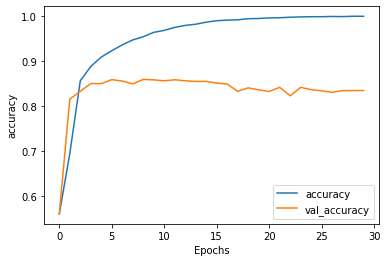

In [45]:
plot_graphs(history, "accuracy")


there is convergence to a more or less good measure of learning accuracy, and it holds for the validation set as well.

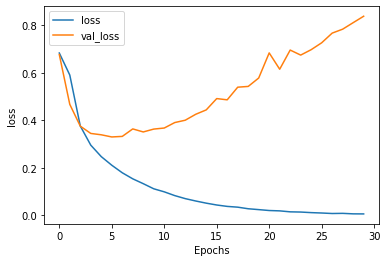

In [46]:
plot_graphs(history, "loss")


There is more penalty in the model predictions however over the learning epochs for the test set.

Presumably it seems like our model has overfitting - How would you fix it?
This code is left for experimentation, try changing the parameters and dataset splittings, perhaps including hyperparameter optimization by yourself!!

Here is an example of how we can decode a sequence and extract its tokens and label

In [247]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print("Secuencia con padding decodeada a texto \n",decode_sentence(padded_train[6]))
print("Secuencia de tokens con padding \n",sequences_train[6])
print("Medida sarcasmo/no sarcasmo",y_train[6])

Secuencia con padding decodeada a texto 
 army successful him left are candidates out all to died to season 'complete hate san fried ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Secuencia de tokens con padding 
 [1761, 2254, 115, 501, 24, 861, 34, 38, 2, 1260, 2, 331, 12732, 664, 1261, 8908]
Medida sarcasmo/no sarcasmo 1


The dimensions of the embedding weights matrix are printed above, in this case it composes a mapping of :

In [53]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(26000, 16)


More sarcasm classification examples!!!

In [60]:
sentence = [
            "study reveals babies are stupid",
            "drugs win drug war",  
            "game of thrones season finale showing this sunday night"
]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen=max(total_lens), padding=padding_type, truncating=trunc_type)

print(model.predict(padded))

[[0.9869716 ]
 [0.35880464]
 [0.00160584]]


In [66]:
# se redondean los valores de predicción para dar lugar a las etiquetas de clase

test_sarcasm_results = model.predict(padded_test)
binaryrounded = []
for sarcasm_rate in test_sarcasm_results:
    binaryrounded.append(round(sarcasm_rate[0]))

**Validation metrics**: Precision, accuracy, sensitivity and F1 score.

'micro': Calculate global metrics by counting total true positives, false negatives and false positives.

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=binaryrounded))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=binaryrounded, average='micro'))
print('Sensibilidad - Recall: %.3f' % recall_score(y_true=y_test, y_pred=binaryrounded, average='micro'))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=binaryrounded, average='micro'))


Exactitud - Accuracy: 0.834
Precision: 0.834
Sensibilidad - Recall: 0.834
F1: 0.834


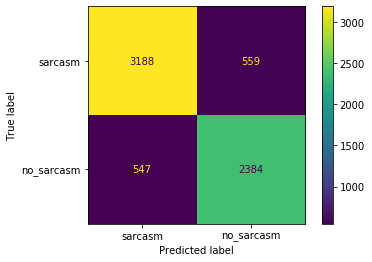

In [248]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
classNames = np.unique(y)
confusionmatrix = confusion_matrix(y_test, binaryrounded)
disp = ConfusionMatrixDisplay(confusionmatrix, display_labels = ['sarcasm','no_sarcasm'])
disp.plot()
plt.show()

<a id='#Parte_3'></a>

# Parte_3

# Application of a recurrent neural network : Bidirectional LSTM
---

Contextual learning of sequences

In summary it is an application of a sequence of layers of neural networks per sequence token position. The idea is to transmit for each layer a weight that gives context of the tokens appeared prior to the sequence, as this image illustrates.

In [241]:
#  __                                                          
# |_       _  _     .  _ .  _   _     _  _   _   _  |_   _  |_ 
# |__ |_| |  (_) \/ | _) | (_) | )   _) (_) | ) (_) |_) (_) |_ 
#                                               _/             

Out of curiosity I delved further into the world of natural text processing with tensorflow and the keras deep learning library, and found the possibility to generate text with special neural networks called **Recurrent Neural Networks**.

These neural networks aim at learning sequence patterns that text elements may have : the importance of learning lies on long and short term contextual learning between tokens.


<img src="images/RNN.png" width="500px">

Since Eurovision was being held around that time, I was inspired to try to generate a model that would be trained from the lyrics of the winning songs of the contest, predicting the text of a song. Hopefully you can learn from this text generation code example as well!!

Eurovision songs json import

In [249]:
df_eurovision = pd.read_json("./data/eurovision-lyrics.json",orient='index')

We reassign the pandas index

In [75]:
df_eurovision = df_eurovision.set_index('#')

## Taking the songs that have won the first places in the competition, which are written in English.

In [154]:
intval = []
for contest_place in df_eurovision['#.1'].values.tolist():
    if contest_place == '-':
        intval.append(26)
    else:
        intval.append(int(contest_place))
df_eurovision['#.1']=intval

df_primeras = df_eurovision[(df_eurovision['#.1']==1)&(df_eurovision['Language'] == 'English')]
df_primeras

,Country,#.1,Artist,Song,Language,Pl.,Sc.,Eurovision_Number,Year,Host_Country,Host_City,Lyrics,Lyrics translation
#,,,,,,,,,,,,,
17,United Kingdom,1,Patricia Bredin,All,English,7,6,2,1957,West Germany,Frankfurt,All the golden dreams of yesterday\nAll the fr...,English
126,Ireland,1,Butch Moore,Walking the Streets in the Rain,English,6,11,10,1965,Italy,Naples,My poor heart feels like breaking\n‘Cause I’ll...,English
841,Latvia,1,Brainstorm,My Star,English,3,136,45,2000,Sweden,Stockholm,My friends gonna call me: hey dreamer\nThe sta...,English
919,Belarus,1,Alexandra & Konstantin,My Galileo,English,-,-,49,2004,Turkey,Istanbul,"I'm no stay-at-home, and heady\nIs my quest an...",English
930,Albania,1,Anjeza Shahini,The Image of You,English,7,106,49,2004,Turkey,Istanbul,How strange the feeling in your soul\nWhen lov...,English
974,Bulgaria,1,Kaffe,Lorraine,English,-,-,50,2005,Ukraine,Kiev,Standing here alone again\nWaiting for the mom...,English
993,Armenia,1,André,Without Your Love,English,8,129,51,2006,Greece,Athens,Drumming hearts and your silent words of love\...,English
1035,Georgia,1,Sopho,Visionary Dream,English,12,97,52,2007,Finland,Helsinki,I'll dream up tales and rhymes\nIn visionary d...,English
1078,Azerbaijan,1,Elnur & Samir,Day After Day,English,8,132,53,2008,Serbia,Belgrade,For peace we pray\nSave us from all fears\nOh ...,English


All values in the lyrics column are transformed to raw text. Capital letters are also removed.

Since this is more of a generative experiment than an analysis of the model accuracy, we will not need to separate by training and test sets this time

In [164]:
lyric_corpus = str()

for lyrics in df_primeras['Lyrics'].values.tolist():
    lyric_corpus += lyrics

The string with all the texts is then moved to a list with a phrase from the song in each element.

In [165]:
lyric_corpus = lyric_corpus.lower().split("\n")

first 3 sentences of the first song

In [166]:
lyric_corpus[0:3]

['all the golden dreams of yesterday',
 'all the fragrance of a bygone may',
 'all the words two hearts in love can say']

In [167]:
tokenizer.fit_on_texts(lyric_corpus)
total_words = len(tokenizer.word_index) + 1

print('Total words used in subset :', total_words)

Total words used in subset : 25925


Sequencing of each phrase and the following phrases

In [168]:
#with the prediction motif, the first token is taken first and 
#the following tokens are stored additionally in another variable
input_sequences = []
for line in lyric_corpus:
    token_list=tokenizer.texts_to_sequences([line])[0] 
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [169]:
# make the padding of the sequence, put it in a numpy array
# the padding or the set of zeros are put before the tokens in this case
# the sequence length will be that of the longest sequence length

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

#### Model construction

* The `Sequential` defines the presence of concatenation of layers of encoders or neural networks.
* To this we add the `Embedding` of the token sequences, this time without reducing. **mapping vectors to tokens of 250 elements. 
* These vectors are passed sequentially to a type of `Bidirectional` RNN, the `Long Short Term Memory (LSTM)`. It is said to be bidirectional because it is composed of two overlapping layers of RNN that learns the sequence context in both directions. Each of these two RNN layers has a total of 150 hidden nodes.
* Finally, the output or vectors that have collected the context of the words are passed to a feed forward neural network with the same number of output nodes as words in the token dictionary. This last layer finally gives us the word predictions.
* adam optimizer
* Accuracy metrics are made along the learning epochs by assessing the categorical cross-entropy.

In [170]:
model = Sequential()
model.add(Embedding(total_words, 250, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax')) 
# tipo de activacion especial, exponencial normalizada, es una generalización de la Función logística
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
# régimen de entropía cruzada
history = model.fit(xs, ys, epochs=100, verbose=1)
print(model.summary())
print(model)

Epoch 1/100


C:\Users\naata\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


52/52 [==============================] - 8s 114ms/step - loss: 6.9309 - accuracy: 0.0429
Epoch 2/100
52/52 [==============================] - 6s 113ms/step - loss: 4.7116 - accuracy: 0.1433
Epoch 3/100
52/52 [==============================] - 6s 113ms/step - loss: 3.5287 - accuracy: 0.3074
Epoch 4/100
52/52 [==============================] - 6s 123ms/step - loss: 2.5941 - accuracy: 0.4532
Epoch 5/100
52/52 [==============================] - 6s 125ms/step - loss: 1.9009 - accuracy: 0.5554
Epoch 6/100
52/52 [==============================] - 7s 127ms/step - loss: 1.3913 - accuracy: 0.6442
Epoch 7/100
52/52 [==============================] - 6s 124ms/step - loss: 1.0325 - accuracy: 0.7453
Epoch 8/100
52/52 [==============================] - 7s 140ms/step - loss: 0.8038 - accuracy: 0.7844
Epoch 9/100
52/52 [==============================] - 7s 131ms/step - loss: 0.6835 - accuracy: 0.8255
Epoch 10/100
52/52 [==============================] - 7s 129ms/step - loss: 0.5203 - accuracy: 0.8604
E

Learning graphs by time period

In [171]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

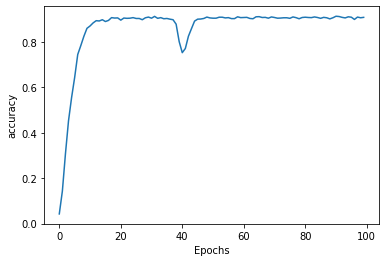

In [172]:
plot_graphs(history, 'accuracy')


## Text generation!!
For this, the following python function is written. the function performs per number of following words specified and seed text the preprocessing, instancing the model for prediction of the next token, getting the most probable token in `indexnumclass` variable and converting the token to text

In [212]:
def write_the_next_eurovision_sentence(seed_text, next_words):
    
    for _ in range(next_words):
        
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        
        predicted = model.predict(token_list)
        classes = np.round(predicted).astype(int)
        indexnumclass=np.argmax(classes)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == indexnumclass:
                output_word = word
                break
        seed_text = seed_text + " " + output_word
        
    return seed_text

In [213]:
inputtext = "My poor heart"
write_the_next_eurovision_sentence(inputtext, 10)

'My poor heart dreamed of time and space     '

In [216]:
inputtext = "I love the"
write_the_next_eurovision_sentence(inputtext, 20)

'I love the stars you are watching are so far away from here my love can say we rhymes so rhymes  '

In [220]:
inputtext = "I'm sad cause i'm"
write_the_next_eurovision_sentence(inputtext, 20)

"I'm sad cause i'm here again i'll wait for your name again saying prayers so rhymes        "

In [222]:
inputtext = "Everyone has"
write_the_next_eurovision_sentence(inputtext, 10)

'Everyone has must         '

In [225]:
inputtext = "you"
write_the_next_eurovision_sentence(inputtext, 20)

'you have to ask and i will show right            '

In [227]:
inputtext = "my darling"
write_the_next_eurovision_sentence(inputtext, 20)

'my darling you are walking are so high and             '

It seems that perhaps the model works better for generating sentences if the seed has prepositions or the sentence has an open ending

I will try to force the prediction by feeding a seed each time a sentence is finished predicting, this time with the first 4 words and not the whole sentence. For this, I will create the following procedure

In [239]:
def keep_writing_the_next_eurovision_sentence(seed_text, next_words, rounds = 10):
    text = write_the_next_eurovision_sentence(seed_text, next_words)
    text += "\n"
    for i in range(rounds):
        corpus_sentences = "".join(df_primeras['Lyrics'].values.tolist()).split("\n")
        random_index = np.random.randint(0, len(corpus_sentences)-1)
        newseed = corpus_sentences[random_index]
        newseed = newseed.split(" ")[0:4]
        newseed = " ".join(newseed)
        text += write_the_next_eurovision_sentence(newseed, next_words)
        text +="\n"
    return text
    

So this will be the next predicted winning eurovision song!!

In [240]:
inputtext = "my darling"
result = keep_writing_the_next_eurovision_sentence(inputtext, 20)
print(result)

my darling you are walking are so high and             
And if you gonna join me i'll be your guide              
Day... after day i go through the motions             
No matter how many miles you walk away from me lorraine in the rain will keep falling you rhymes rhymes    
What you'll decide? some                   
What I lose, what i find without your love you have to ask and i will show rhymes love rhymes    
Forget tomorrow we can do tonight again again again             
Sharing my history                    
For now let’s leave them all behind love you behind              
                    
Do whatchya, whatchya, whatchya want tomorrow we can do tonight again again again again          

